<a href="https://colab.research.google.com/github/11PRIMUS/Early-Stage-Cancer-Prediction/blob/main/Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import shutil
import glob

In [4]:
#count no of img 1-brain tumor and 0-healthy
ROOT_DIR="/content/drive/MyDrive/8914"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)) )

number_of_images.items()

dict_items([('0', 410), ('1', 75)])

Splitting of Data


*   70% for training
*   15% for validation

*   15% for testing






In [5]:
def dataFolder(p, split=0.7):
    # Check if the target folder exists
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for dir in os.listdir(ROOT_DIR):
            # Create subdirectory in the new folder
            os.makedirs(os.path.join("./" + p, dir))

            # Select a random subset of images
            number_of_images_in_dir = number_of_images[dir]
            selected_images = np.random.choice(
                a=os.listdir(os.path.join(ROOT_DIR, dir)),
                size=(math.floor(split * number_of_images_in_dir)),
                replace=False
            )

            # Copy selected images to the new location and delete originals
            for img in selected_images:
                original_path = os.path.join(ROOT_DIR, dir, img) # Original path
                destination_dir = os.path.join("./" + p, dir)   # Destination folder
                shutil.copy(original_path, destination_dir)     # Copy image
                os.remove(original_path)                        # Remove original image
    else:
        print(f"{p} folder already exists")

In [6]:
dataFolder("train",0.8)

In [7]:
dataFolder("val",0.1)

In [8]:
dataFolder("test",0.1)

preparing data using  imagegenrator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import the ImageData
from keras.applications.mobilenet import preprocess_input

In [10]:
def preprocessingImages1(path):
  """
  input:path
  output:pre processed images
  """
  image_data=ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )
  image=image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image

In [11]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 388 images belonging to 2 classes.


In [12]:
train_data.class_indices

{'0': 0, '1': 1}

In [13]:
def preprocessingImages2(path):
  """
  input:path
  output:pre processed images
  """
  image_data=ImageDataGenerator(
      preprocessing_function=preprocess_input
  )
  image=image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image

In [14]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 48 images belonging to 2 classes.


In [15]:
path="/content/val"
val_data=preprocessingImages2(path)

Found 48 images belonging to 2 classes.


Model Training

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet,preprocess_input
import keras

In [17]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
for layer in base_model.layers:
  layer.trainable=False

In [19]:
X=Flatten()(base_model.output)
X=Dense(units=1,activation='sigmoid')(X)

model=Model(base_model.input,X)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) # Changed loss to 'binary_crossentropy'

In [21]:
##call back
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc=ModelCheckpoint(filepath="./best_model.keras",monitor='val_accuracy',verbose=1,save_best_only=True) # Changed the file extension to .keras
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
cb=[mc,es]

In [22]:
# Define steps_per_epoch, validation_steps, epochs, and callbacks
steps_per_epoch = len(train_data) // 32  # Adjust as necessary
validation_steps = len(val_data) // 32   # Adjust as necessary
epochs = 30

# Callbacks like ModelCheckpoint (if `mc` is defined)
# Assuming you define your callback earlier
hist = model.fit(train_data,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=val_data,
                 validation_steps=validation_steps,
                 epochs=epochs,
                 verbose=1,
                 callbacks=[mc])  # Make sure 'mc' is a valid ModelCheckpoint


Epoch 1/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7402 - loss: 1.6077
Epoch 1: val_accuracy improved from -inf to 0.97917, saving model to ./best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - accuracy: 0.7497 - loss: 1.5674 - val_accuracy: 0.9792 - val_loss: 0.3383
Epoch 2/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9170 - loss: 0.6257
Epoch 2: val_accuracy did not improve from 0.97917
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9160 - loss: 0.6258 - val_accuracy: 0.9792 - val_loss: 0.2910
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9452 - loss: 0.3441
Epoch 3: val_accuracy did not improve from 0.97917
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9454 - loss: 0.3417 - val_accuracy: 0.9792 - val_loss: 0.1492
Epoch 4/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9698 - loss: 0.1043
Epoch 4: val_accuracy did not improve from 0.97917
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9704 - l

In [23]:
acc=model.evaluate(test_data)[1]
print("the model Accuracy is = ",acc*100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0048
the model Accuracy is =  100.0


In [24]:
# model graphical representation
h=hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

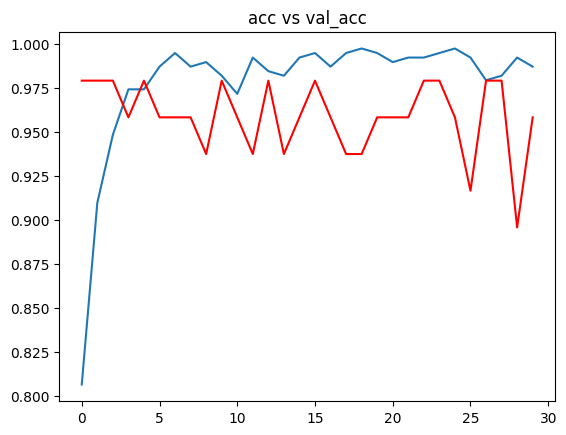

In [25]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red') # Changed 'val_accuracy' to 'accuracy'
plt.title("acc vs val_acc")
plt.show()

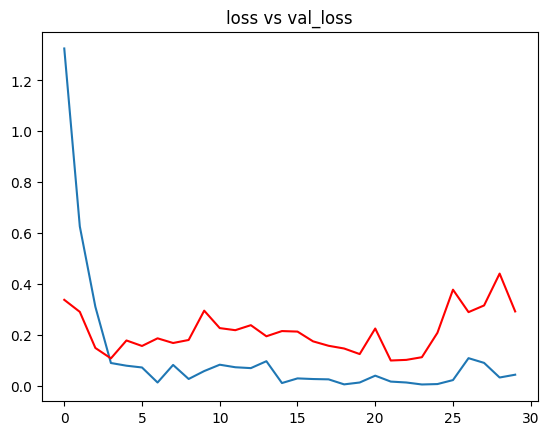

In [26]:
plt.plot(h['loss'])

# Check if 'val_loss' exists in h before plotting
if 'val_loss' in h:
    plt.plot(h['val_loss'],c='red')
plt.title('loss vs val_loss')
plt.show()

In [27]:
from keras.preprocessing import image

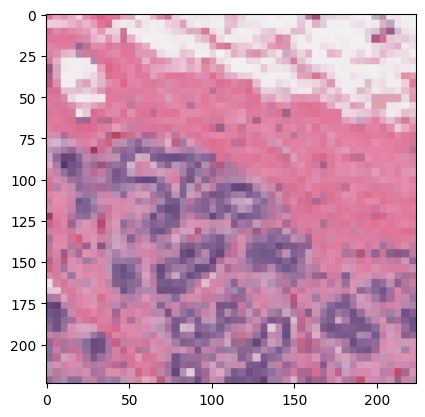

Input shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability: 4.1737095557436987e-07
Tumor not Detected in MRI


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# path to the image
path = "/content/test/0/8914_idx5_x2151_y1551_class0.png"
# Load the image and resize it to 224x224
img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img) / 255.0

# Plot of img
plt.imshow(input_arr)
plt.show()

print("Input shape:", input_arr.shape)

# Expand the dimensions to match the model input
input_arr = np.expand_dims(input_arr, axis=0)

# Assuming `model` is preloaded and compiled, predict the result
pred = model.predict(input_arr)[0][0]

# Interpret the prediction
print(f"Predicted probability: {pred}")

# Use 0.5 as the threshold for classification
# for threshold 0 it didn't work
if pred < 0.5:
    print("Tumor not Detected in MRI")
else:
    print("Tumor Detected in MRI")
